<a href="https://colab.research.google.com/github/mohammedbentiress/Sentiment-Analysis/blob/master/Word2Vec_embedding_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Google Drive locally

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Importing Required Libraries

In [0]:
import re
import csv
import json
import numpy as np
import pandas as pd
from numpy import array
from numpy import zeros
from numpy import asarray
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import save_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPool1D, Embedding, Conv1D, LSTM, GRU,Bidirectional,SpatialDropout1D
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

# Define functions for treatement

In [0]:

# extracting  data from dataset tweet-sentiment
def load_dataset(filename):
    # read the dataset 
    tweets = pd.read_csv(filename, encoding="ISO-8859-1")

    # tweet listing
    text = []
    sentences = list(tweets['tweet'].astype(str))
    for sen in sentences:
        text.append(sen)

    # sentiment listing
    label = tweets['sentiment']
    label = np.array(list(map(lambda x: 1 if x=="positive" else 0, label)))
    
    return text,label

# load the embedding model 
def create_embedding_matrix(filename,vocabulary):
    vocab_size = len(vocabulary) + 1
    word_vectors = KeyedVectors.load_word2vec_format(filename, binary=True)
    embedding_mat = zeros((vocab_size, embedding_dim))
    for word, index in vocabulary.items():
        try:
            embedding_vector = word_vectors.get_vector(word)
            if embedding_vector is not None:
                embedding_mat[index] = embedding_vector

        except KeyError:
            embedding_mat[index]=np.random.normal(0,np.sqrt(0.25),embedding_dim)
    del(word_vectors)

    nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_mat, axis=1))
    # print some informations about our vocabulary
    print(" vocabulary size : number of unique words in the vocabulary ",vocab_size)
    print(" percentage of the vocabulary covered by the pretrained model : ",(nonzero_elements/vocab_size)*100)
    return embedding_mat


# creating the classification model
def create_classifier(classification_model,embeddings):
    #add layers
    classification_model.add(embeddings)
    classification_model.add(Bidirectional(LSTM(300)))
    classification_model.add(Dense(300, activation='relu'))
    classification_model.add(Dense(1, activation='sigmoid'))
    
    # compile 
    classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    # print summary of the model
    print(classification_model.summary())
    return classification_model


# draw plots
def draw_plots(model_history):
    
    # accuracy plot
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','valid'], loc='upper left')
    plt.show()

    # loss plot
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','valid'], loc='upper left')
    plt.show()


# creating the model by using the functions above 

First we unzip the file that contains tweets

In [0]:
import zipfile
path_to_zip_file= "/content/gdrive/My Drive/PFA/Sentiment-Analysis/Data/clean_tweets.zip"
directory_to_extract_to="/content/gdrive/My Drive/PFA/Sentiment-Analysis/Data/clean_tweets.csv"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

we need to divide our dataset into train and test sets. The train set will be used to train our deep learning models while the test set will be used to evaluate how well our model performs.

We can use train_test_split method from the sklearn.model.selection module

In [0]:
# get the tweets and their sentiment
dataset_file ="/content/gdrive/My Drive/PFA/Sentiment-Analysis/Data/clean_tweets.csv/clean_tweets.csv"
X,y = load_dataset(dataset_file)

# splitting data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
Sentences_train = X_train

**Preparing the Embedding Layer**

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [0]:
tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

You will notice that the size of each list is different. This is because sentences have different lengths.

We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called padding.

The following script finds the vocabulary size and then perform padding on both train and test set.

In [0]:
maxlen = 100 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We will use GloVe embeddings to create our feature matrix.
Convolutional neural networks have been found to work well with text data as well. Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data.

In [9]:
#!wget -P '/content/gdrive/My Drive/PFA/Sentiment-Analysis/WORD2VEC/GoogleNews-vectors-negative300.bin.gz' -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
embedding_dim = 300
word2vec_file = '/content/gdrive/My Drive/PFA/Sentiment-Analysis/WORD2VEC/GoogleNews-vectors-negative300.bin.gz/GoogleNews-vectors-negative300.bin.gz'
embedding_matrix = create_embedding_matrix(word2vec_file, tokenizer.word_index)

# create embedding layer
embedding_layer = Embedding(len(tokenizer.word_index)+1, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


 vocabulary size : number of unique words in the vocabulary  228200
 percentage of the vocabulary covered by the pretrained model :  99.99956178790535


**Text Classification with  Convolutional Neural Network**

Convolutional neural networks have been found to work well with text data as well. Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data

In [10]:
# create the classifier : convolutional neural network 
model = Sequential()
model = create_classifier(model,embedding_layer)

# evaluating the model :  validation-20% from the training set 
history = model.fit(X_train, y_train, batch_size=1500, epochs=5, verbose=1, validation_split=0.2)

# evaluating the model : test set 20% from the whole dataset 
print("Evaluating the test set")
score = model.evaluate(X_test, y_test, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          68460000  
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 70,083,001
Trainable params: 70,083,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
683/683 [==============================] - 648s 949ms/step - loss: 0.4394 - acc: 0.7940 - val_loss: 0.4110 - val_acc: 0.8108
Epoch 2/5
683/683 [==============================] - 639s 936ms/step - loss: 0.3821 - acc: 0.8273 - va

In the scipt above, we use the fit method to train our neural network. Notice we are training on our train set only. The validation_split of 0.2 means that 20% of the training data is used to find the training accuracy of the algorithm.

To evaluate the performance of the model, we can simply pass the test set to the evaluate method of our model.

To check the test accuracy and loss, execute the following script:

In [11]:
print("Test Score    :", score[0])
print("Test Accuracy :", score[1])

Test Score    : 0.5427528619766235
Test Accuracy : 0.8071218729019165


Let's try to plot the accuracy differences for training and test sets.

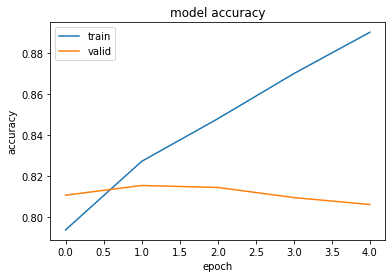

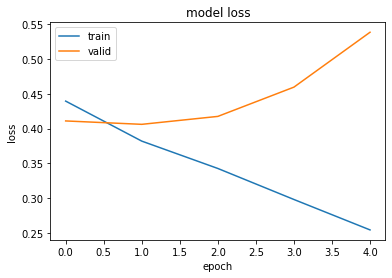

In [12]:
draw_plots(history) 

**Making Predictions on diffrente tweets** 

To predict the sentiment of this tweets, we have to convert this tweets into numeric form. We can do so using the tokenizer that we created in word embedding section. The text_to_sequences method will convert the sentence into its numeric counter part.

Next, we need to pad our input sequence as we did for our corpus. Finally, we can use the predict method of our model and pass it our processed input sequence

In [13]:
txt = ["awesome movie","terrible movie","that movie really sucks","i like that movie"]
txt = tokenizer.texts_to_sequences(txt)
txt = pad_sequences(txt, padding='post', maxlen=maxlen)
prediction = model.predict(txt)
print('\n prediction for \n',prediction[:,0])


 prediction for 
 [0.99761    0.01715513 0.01841559 0.99669516]


**Saving Model and Dictionnary**

In [0]:
# save model and weights
save_model(
    model,
    "/content/gdrive/My Drive/PFA/Sentiment-Analysis/TrainedModels/WORD2VEC/model_LSTM_word2vec300.h5",
    overwrite=True,
    include_optimizer=True
)

# save vocabulary dictionnary
#create_csv('/content/gdrive/My Drive/PFA/Sentiment-Analysis/TrainedModels/GLOVE/dict_sentimentAnalysis.csv')
